# Special method `CKdisc` for non-smooth problems

The [Cash Karp](https://doi.org/10.1145/79505.79507) variable order explicit Runge-Kutta method is created for non-smooth problems. The 'disc' in `CKdisc` stands for discontinuous (derivatives of the solution).

## The method

The class `CKdisc` codes the variable order Runge-Kutta method as described by Cash and Karp. The method intends to integrate each step with its 5th order method. While it calculates through the Runge-Kutta stages, it assesses the convergence a couple of times. It only calculates the next stage if convergence is likely. The step can be propagated with three different solutions:
* A full step with a 5th order method
* 3/5th of the step with a 3rd order method
* 1/5th of the step with a 2nd order method

The last two are fallback solutions. The idea is that if a discontinuity happens after 3/5th of the step, the solution before that point may still be acceptable, and because the step is smaller, a lower order may be sufficient. 

So by doing multiple assessments and having multiple fallback solutions, the `CKdisc` method of Kash and Karp tries to integrate non-smooth problems efficiently. `CKdisc` can also have advantages for solving a problem at high tolerance, because this can make problems appear non-smooth to the method.

The stability regions of all embedded methods are shown in the figure below. The stability interval for imaginary poles is poor (except for the 3rd order embedded method).

![Stability regions](stability%20regions/stabilityCKdisc.png)

The class `CK5` is a *fixed order* variant that uses only the fifth order method and fourth order error estimate from `CKdisc`. I have appended a free, 4th order, C1-continuous interpolant. The error of this interpolant is shown in the figure below. Unfortunately, the error is larger than the error of the 4th order embedded method. `CKdisc` uses the same interpolant if the integration is propagated with the 5th order method. If it propagates with a lower order fallback solution, then a C1-coninuous cubic Hermite interpolant is used.

![interpolant](interpolants/interpolation_CK5.png)

## Problem definition

The performance is tested with a simplified problem: F2 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set. This problem has a discontinuity at each integer value of `t`, but this will not be exploited. Such knowledge may not be available for more realistic problems. The end of t_span is reduced from 20 to 10, with respect to the original DETEST problem.

In [1]:
problem = {'fun' : lambda t, y: ( (55 - 1.5*y) if (t%2 >= 1.) else (55 - 0.5*y)),
            'y0' : [110.],
        't_span' : [0., 10.]}

## Reference solution

First a reference solution is created by solving this problem with low tolerance.

In [2]:
from scipy.integrate import solve_ivp

reference = solve_ivp(**problem, atol=1e-12, rtol=1e-12, dense_output=True)

## Solution plot

A plot of the solution clearly shows the that the solution is non-smooth. The solver does not know where to expect the discontinuous derivatives. It needs to reduce the step near most discontinuities.

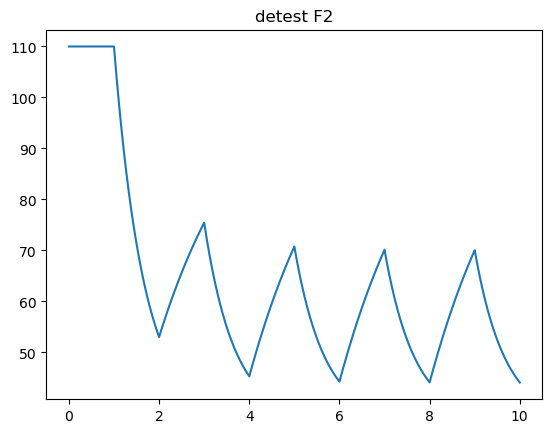

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(reference.t, reference.y.T)
plt.title('detest F2')
plt.show()

## Efficiency plot
The method is efficient if it can solve problems to low error with low cost. I will use the number of function evaluations as measure of cost. For the error measure I wil use the RMS of the error norm over all solution points. A function to calculate it is:

In [4]:
def rms_err_norm(solution, reference):
    error = solution.y - reference.sol(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Let's solve this problem with `RK45`, `CKdisc` and `CK5` at some higher absolute tolerance values and make a plot to show the efficiency of these methods. 

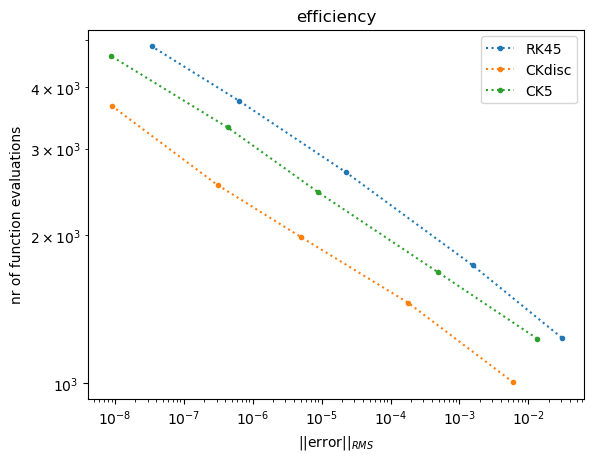

In [5]:
import numpy as np
from extensisq import CK5, CKdisc

methods = ['RK45', CKdisc, CK5]
tolerances = np.logspace(-3, -9, 5)

plt.figure()
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        if method==CK5:
            sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method,
                            sc_params="standard")
        else:
            sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method)
        err = rms_err_norm(sol, reference)
        e.append(err)
        n.append(sol.nfev)
    plt.loglog(e, n, '.:', label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('nr of function evaluations')
plt.title('efficiency')
plt.show()     

The variable order Cash Karp method `CKdisc` solves this problem roughly 1.5 times more efficiently than the "RK45" method; at least if cost is measured by the number of function evaluations. The step size controller is set to 'standard' for `CK5`, because the default Gustafsson controller slows down steps size changes too much for this problem. Now it performs slightly better than "RK45", but not as good as the variable order method.

## Discussion

The `CKdisc` works as advertised. It solves non-smooth problems relatively efficiently. So if your problem is non-smooth, try `CKdisc`. However, also take into consideration that the dense_output has a relatively high error, and that the stability for imaginary poles (undamped resonances) is poor.

For smooth problems `CKdisc` and `CK5` may still beat `RK45`, but the opposite is more common. Just, give it a try for your problem, especially if you don't need low tolerance. For smooth problems and medium (default) tolerance I recommend `BS5` and for even lower tolerances scipy's `DOP853`, or one of extensisq's methods `CFMR7osc`, `Pr7`, `Pr8` or `Pr9`.